<p align="center">
  <img width="300" height="290" src="https://i.imgur.com/mu6ZuGT.jpg">
</p>

<h1><b>TC4033</b></h1>
<h1><b>Visión computacional para imágenes y video</b></h1>
<h3><b>3.2 Google Colab -  Algoritmos de mejoramiento de imágenes en el dominio espacial</b></h3>
<h3><b>Docentes:</b> Dr. Gilberto Ochoa Ruiz, Mtra. María Guadalupe Marcos Abularach</h3>

<h2><b>Equipo 30:</b></h2>

- Julio Baltazar Colín: A01794476
- Julio Osvaldo Hernández Bucio: A01794366
- Helmy Andrea Moreno Navarro: A01793918
- Maricel Parra Osorio - A01793932
- Yeison Fernando Villamil Franco: A01793803

_________________________


#**Introducción**



El presente trabajo tiene como fin explorar un poco más los procesamientos que se pueden realizar a través de los métodos de Visión Computacional. En esta ocasión revsiaremos como los filtros nos ayudan a crear una variante de la imagen original, posiblemente haciendo mejoras en ella ya que trabaja con sus valores de pixeles y hace una combinación para dar un resultado favorable en las propiedades que la integran, ya sea estrayendo mejor brillo, iluminación, mejora de imágenes borrosas, realce, detección de contornos o líneas, entre otras.

En el Procesamiento de imágenes

_"Hay dos tipos principales de procesamiento de imágenes: filtrado de imágenes y deformación de imágenes: <b>El filtrado de imágenes</b> cambia el rango (es decir, los valores de píxeles) de una imagen, por lo que los colores de la imagen se modifican sin cambiar las posiciones de los píxeles, mientras que <b>la deformación de imágenes</b> cambia el dominio (es decir, las posiciones de los píxeles) de una imagen, donde los puntos se asignan a otros puntos sin cambiar los colores"._[1]

Para el siguiente Challenge, usaremos operadores de convolución que nos ayudará en **el filtrado de imagen** extrayendo información importante de las imágenes, con filtros de **detección de bordes** con los operadores de **Prewitt, Sobel y Laplaciano**, el realce de una imagen con el **algoritmo de Canny** y algunos usos en el sector de la Salud.

[1] Tutorial 1: Filtrado de imágenes. Tomado de: https://ai.stanford.edu/~syyeung/cvweb/tutorial1.html

# **4. Image Convolution**

## **Table of Contents**
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)
4. [Challenge](#challenge)

  - 1. [Prewitt, Sobel y Laplaciano](#detectores_de_linea)
    - 1.1 [Prewitt](#prewitt)
    - 1.2 [Sobel](#sobel)
    - 1.3 [Laplaciano](#laplaciano)

  - 2. [Image enhancement and image masking](#enhancement)
  - 3. [Prewitt, Sobel y Laplaciano](#detectores_de_linea)

## **1. Importing Libraries** <a class="anchor" id="libraries" ></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Simple Convolution <a class="anchor" id="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

![Evidence 3](https://i.imgur.com/AoCuQud.jpg)

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__.

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

## **2. Simple Example**

In [ ]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [ ]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [ ]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros

    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

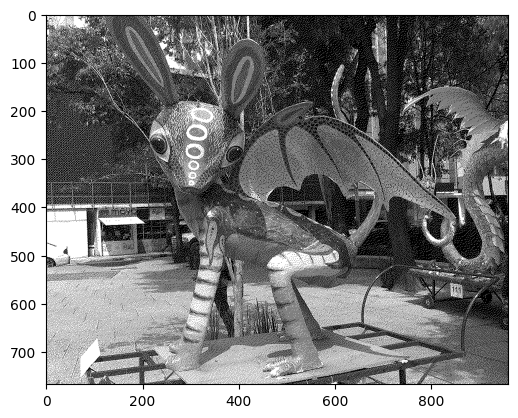

In [ ]:
image_real = Image.open('data/alebrije.jpg')
image = image_real.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

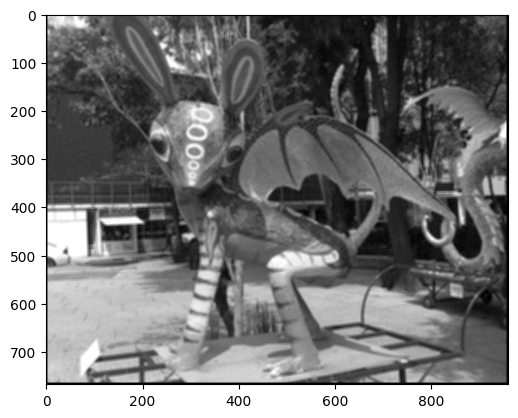

In [ ]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## **3. PyTorch Convolution** <a class="anchor" id="pytorch" ></a>

In [ ]:
from PIL import Image

img = Image.open('data/alebrije.jpg')
img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.

<ipython-input-54-301d2d00b027>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.


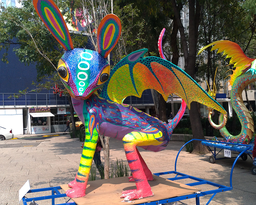

In [ ]:
img

In [ ]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [ ]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [ ]:
input = to_tensor(img)
input.shape


torch.Size([1, 205, 256])

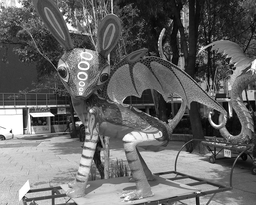

In [ ]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [ ]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [ ]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

tensor([[[0.5037, 0.8610, 0.8196,  ..., 0.2870, 0.2590, 0.1551],
         [0.5399, 1.1377, 1.0538,  ..., 0.3574, 0.3839, 0.3116],
         [0.4711, 0.9971, 1.0472,  ..., 0.3943, 0.4093, 0.3173],
         ...,
         [0.4379, 0.9786, 0.9928,  ..., 0.4904, 0.4836, 0.4036],
         [0.4324, 0.9772, 0.9606,  ..., 0.4851, 0.4864, 0.4196],
         [0.2530, 0.6688, 0.6613,  ..., 0.3400, 0.3536, 0.3200]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [ ]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 205, 256])

In [ ]:
output = conv(input)
output.shape

torch.Size([1, 1, 205, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [ ]:
output.shape

torch.Size([1, 1, 205, 256])

We need to remove the first dimension before converting to a PIL object.

In [ ]:
output.data.squeeze(dim=0).shape

torch.Size([1, 205, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

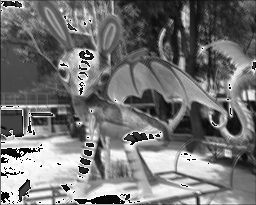

In [ ]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

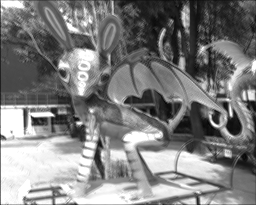

In [ ]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [ ]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

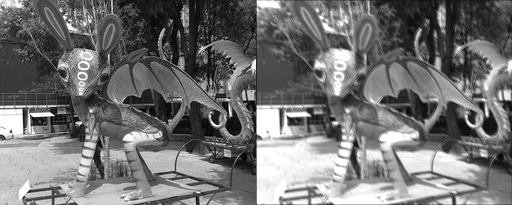

In [ ]:
display(input, output)

### **Identity**

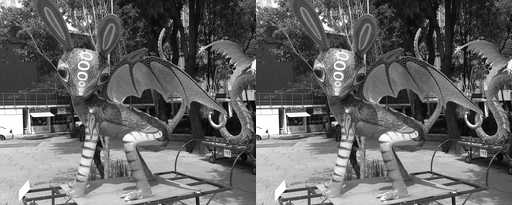

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### **Brighten**

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


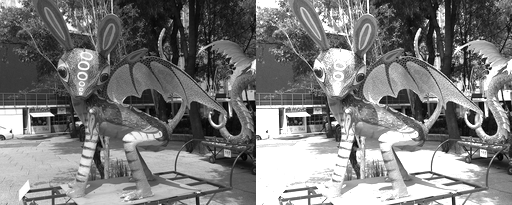

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### **Darken**

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


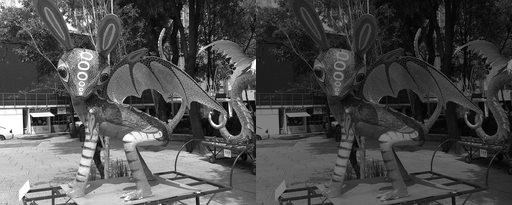

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### **Box blur**

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


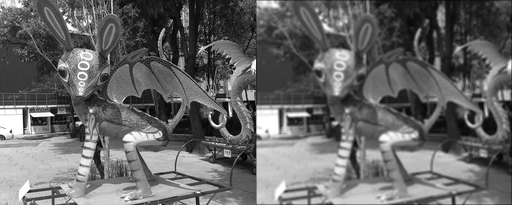

In [ ]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### **Gaussian blur**

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


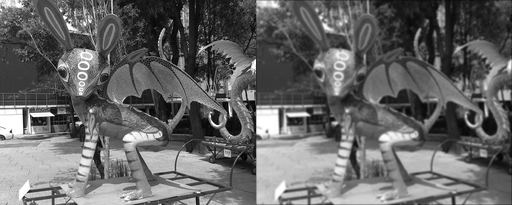

In [ ]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### **Sharpen**

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


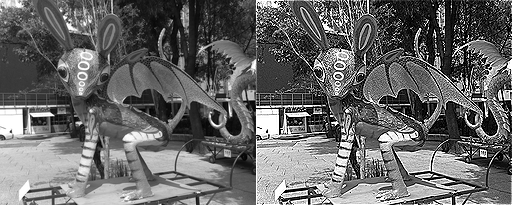

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


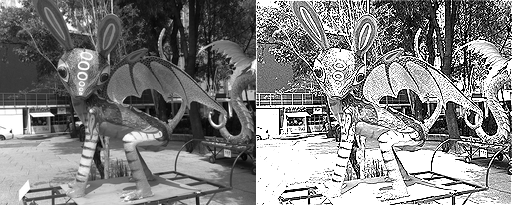

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### **Edge detection**

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


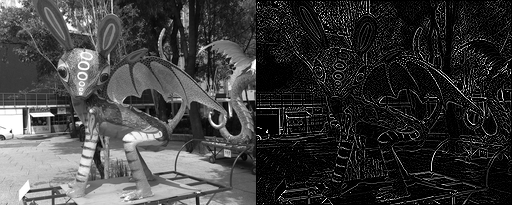

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

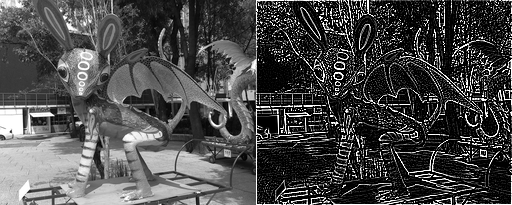

In [ ]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

# **3. Challenge**

Para el presente ejercicio, es muy importante rescatar el siguiente artículo donde, de manera intuitiva hace una explicación de la importancia de la detección de los bordes en las imágenes y nos muestra de forma matemática su aplicación:

Literalemnte menciona:

_"...los bordes son discontinuidades repentinas en una imagen, que pueden surgir de la normalidad de la superficie, el color de la superficie, la profundidad, la iluminación u otras discontinuidades. **Los bordes son importantes por dos razones principales:** **1)** La mayor parte de la información semántica y de forma se puede deducir de ellos, por lo que podemos realizar el reconocimiento de objetos y analizar las perspectivas y la geometría de una imagen. **2)** Son una representación más compacta que los píxeles"._

_"Un gradiente de imagen, que es una generalización del concepto de derivada a más de una dimensión, apunta en la dirección donde la intensidad aumenta más". [2] Si el gradiente es: $$∇ f = [ δ f ⁄ δ x , δ f ⁄ δ y ]$$ entonces la dirección del gradiente sería: $$θ = tan -1 ( δ f ⁄ δ y / δ f ⁄ δ x )$$ y **la resistencia del borde** sería la magnitud del gradiente: $$||∇ f || = √ (δ f /δ x ) 2 +(δ f /δ y ) 2".$$_

> A continuación se realizarán algunas operaciones de acuerdo a este principio.

</br>
</br>
[2] Tutorial Detección de imágenes. Tomado de: https://ai.stanford.edu/~syyeung/cvweb/tutorial1.html

# **1. Prewitt, Sobel y Laplaciano**
> Implementa los detectores de línea siguientes usando código en Python (es decir, sin usar librerías de OpenCV): Prewitt, Sobel y Laplaciano. Investiga la complejidad algoritmica de estos, ¿cuál es más eficiente?

## **1.1. Prewitt**

## **1.2. Algoritmo Detector de líneas Sobel**

El algoritmo de seguimiento de líneas Sobel se basa en el operador Sobel, que es un filtro utilizado para detectar bordes en una imagen. Este operador utiliza máscaras convolucionales para calcular las derivadas de la imagen en las direcciones horizontal y vertical.

En el contexto del seguimiento de líneas, el algoritmo Sobel se aplica para resaltar los cambios de intensidad en la imagen, lo que ayuda a identificar bordes y límites.

### El operador de Sobel.
La versión en 2D del operador Sobel utiliza dos máscaras convolucionales, una para calcular las derivadas en la dirección horizontal (también llamada máscara Sobel-X) y otra para las derivadas en la dirección vertical (máscara Sobel-Y). Estas máscaras son matrices pequeñas que se aplican a la imagen original mediante operaciones de convolución.

La máscara Sobel-X es:

```
-1  0  1
-2  0  2
-1  0  1
```
La máscara Sobel-Y es:

```
-1 -2 -1
 0  0  0
 1  2  1
```

Estas máscaras se aplican para calcular las derivadas en las direcciones horizontal y vertical, respectivamente, y luego se combinan para obtener la magnitud del gradiente. El resultado final es una imagen que resalta los bordes y cambios abruptos de intensidad en la imagen original [1].


### Complejidad Algoritmica

La complejidad algorítmica del operador Sobel depende del tamaño de la imagen. Si la imagen tiene dimensiones M x N donde M es el número de filas y N es el número de columnas. Para aplicar el operador Sobel, se realiza una operación de convolución para cada píxel de la imagen. Cada operación de convolución implica multiplicar los valores de la máscara por los píxeles correspondientes en la región de la imagen y sumar los resultados. Si la máscara es de tamaño $k * k $, la complejidad por píxel es $O(k^2)$


Dado que se aplican las máscaras Sobel-X y Sobel-Y, y luego se combina la información resultante, la complejidad total sería proporcional a $O(K^2 \times 2)$. Sin embargo, al considerar todo el proceso de convolución para cada píxel de la imagen, la complejidad final se vuelve

$O(M \times N \times k^2)$


Es decir su complejidad es de aproximadamente el doble que otros algoritmos de deteccion de lineas que implementan filtros por convolución al emplear dos mascaras [2][3].

[1] Articulo Técnicas de detección de bordes de Sobel frente a Canny: implementación paso a paso:
https://ichi.pro/es/tecnicas-de-deteccion-de-bordes-de-sobel-frente-a-canny-implementacion-paso-a-paso-19440649610602

[1]Edge Detection Using Guided Sobel Image Filtering: Ranjan, R., Avasthi, V. Edge Detection Using Guided Sobel Image Filtering. Wireless Pers Commun 132, 651–677 (2023).
https://doi.org/10.1007/s11277-023-10628-5

[2]Articulo Comparing Edge Detection Methods:
https://medium.com/@nikatsanka/comparing-edge-detection-methods-638a2919476e


## Implementación del Algoritmo de Sobel

In [ ]:
import numpy as np
from scipy import signal
from PIL import Image

In [ ]:
def display(diccionario=None, nrow=None, ncol=None,  vmin=0.0, vmax=1.0):
    """
    Función que permite crea la cantidad de imágenes necesarias
    en función de un diccionario que las contenga
    Returns:
        Imagenes a ser observadas
    """
    fig = plt.figure(figsize=(20, 20))

    for raw, col in enumerate(diccionario):
        img = fig.add_subplot(nrow, ncol, raw + 1)
        img.set_title(f"{col}")
        img.imshow(diccionario[col],  cmap='gray' , vmin=vmin, vmax=vmax)

In [ ]:
def convolucion2Kernels(imagen, kernel1, kernel2):

    filas, columnas = image.shape  # we need to know the shape of the input grayscale image
    resultado = np.zeros_like(image)  # initialization of the output image array (all elements are 0)

    if kernel1.shape != kernel2.shape:
      raise Exception("La dimension de los Kernels debe ser igual.")

    m, n = kernel1.shape

    if m != 3 or n != 3:
        raise Exception("solo se adminten kernels de 3 x 3.")

     # aplicar la convolucin usando 2 kernels
    for i in range(filas - 2):
        for j in range(columnas - 2):
            gx = np.sum(np.multiply(kernel1, imagen[i:i + 3, j:j + 3]))  # kernel x
            gy = np.sum(np.multiply(kernel2, imagen[i:i + 3, j:j + 3]))  # kernel y
            resultado[i + 1, j + 1] = np.sqrt(gx ** 2 + gy ** 2)   # gradient

    return resultado


In [ ]:
def lineas_sobel(imagen):
    # Convertir la imagen a escala de grises si no lo está
    imagen_gris = imagen.convert('L')

    # Obtener los datos de píxeles como una matriz NumPy
    matriz_imagen = np.array(imagen_gris)

    # Definir máscaras Sobel
    mascara_sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    mascara_sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # aplicar el filtro usando las dos mascaras
    magnitud_gradiente = convolucion2Kernels(matriz_imagen,mascara_sobel_x,mascara_sobel_y)

    # Escalar la magnitud para convertirla a formato de píxeles de 8 bits
    magnitud_gradiente = (magnitud_gradiente / np.max(magnitud_gradiente) * 255).astype(np.uint8)

    # Crear una nueva imagen a partir de la matriz resultante
    imagen_resultante = Image.fromarray(magnitud_gradiente)

    return imagen_resultante

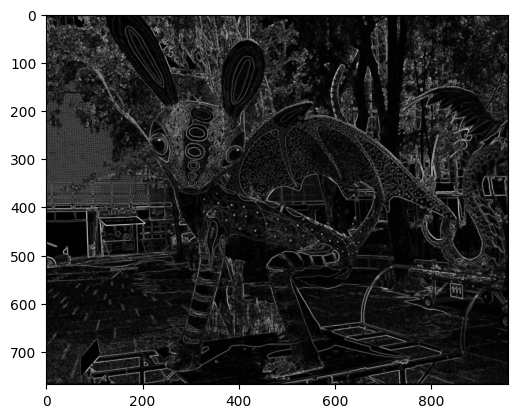

In [ ]:
# aplicando el filtro a la imagen
imagen_original = Image.open(img_data)
imagen_resultante = lineas_sobel(imagen_original)

plt.imshow(imagen_resultante, cmap='gray',vmin=0.0, vmax=255.0)
plt.show()

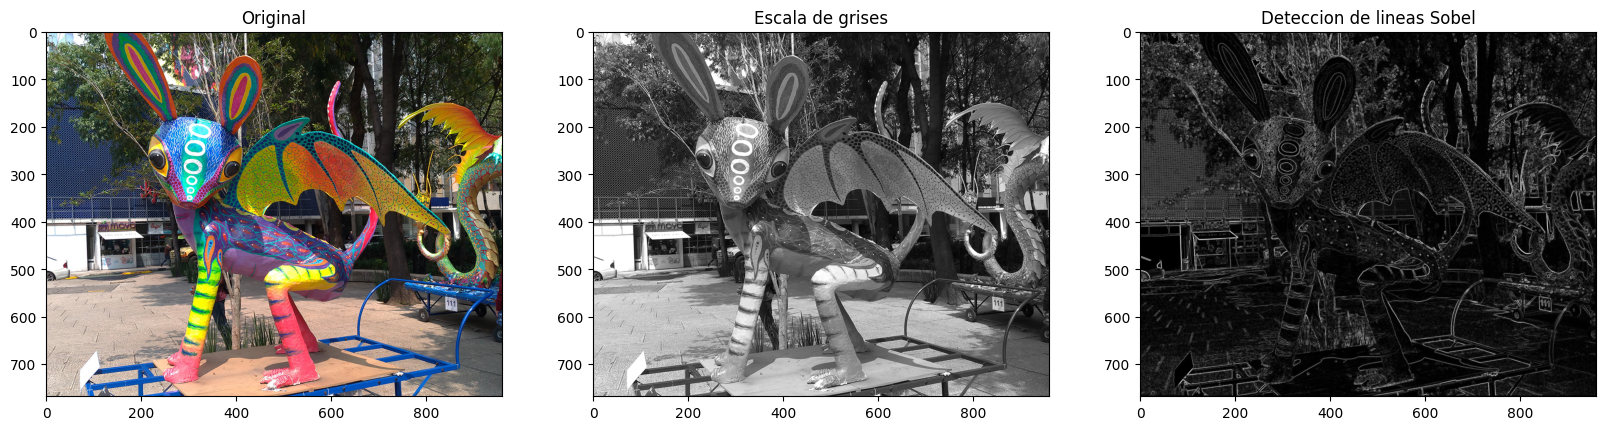

In [ ]:
dict_images = {'Original':imagen_original, 'Escala de grises':imagen_original.convert('L'), 'Deteccion de lineas Sobel':imagen_resultante}
displayVmax(dict_images, nrow=1, ncol=3, vmin=0.0, vmax=255.0)

## **1.3. Laplaciano**

El detector de bordes laplaciano compara las segundas derivadas de una imagen. La detección de bordes laplacianos utiliza filtros que contienen valores negativos en un patrón cruzado. Esto filtros son conocidos de la forma Laplaciano o diagonal laplaciano. Una desventaja que poseen los filtros laplacianos es su sensibilidad al ruido de las imágenes, ya que pueden detectar en las áreas de ruido como si fuesen bordes. Por eso y como buena práctica es importante suavizar la imagen antes de aplicar el kernel. La ecuación es definida de la siguiente manera:

$$
g(x, y) = f(x, y) + c[\nabla^2f(x,y)]
$$

La constante dependerá del tipo de filtro usado, siendo negativo o positivo.

Donde el gradiente que representa la derivada puede ser descrito de la forma:

$$
\nabla^2 = I(x+1, y) + I(x-1, y) + I(x, y+1) + I(x, y-1) - 4I(x, y)
$$

La segunda derivada en el caso de las imágenes
$$
\nabla^2f(x,y) = h(m,n)\bigotimes f(x,y)
$$

Donde:
- $h(m,n)$ = Kernel laplaciano
- $f(x,y)$ = imagen de entrada
- $\bigotimes$ = operación convolucional

Los filtros laplacianos tienen la siguiente forma:

Filtro laplaciano
$$F = \begin{bmatrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0
\end{bmatrix}$$

Diagonal
$$F = \begin{bmatrix}
1 & 1 & 1 \\
1 & -8 & 1 \\
1 & 1 & 1
\end{bmatrix}$$

Considerando que se debe implementar la segunda derivada, es evidente que la complejidad algoritmica de desarrollar la función de solución. Sin embargo, una forma de solución es ir pixel por pixel, calculando el componente matricial para pequeños segmentos de la imagen y posteriormente el gradiente que representa la derivada. Una vez calculado el grandiente, sobre cada pixel se indica un umbral que permite poder cambiar el valor de este cuando el gradiente cumple la condición. Esto representará un borde por medio del kernel laplaciano.

Con el objetivo de poder considerar bordes que posiblemente no son tomados en las partes laterales de la imagen, se asignan valores de cero para que el centro del filtro o kernel laplaciano pueda tener en cuenta estos bordes.

In [ ]:
def image_preprocess(image):
    """
    Procesamiento de la imagen con un padding que permite
    poder dar valores a los bordes laterales de la imagen
    Returns:
        Filtro
    """
    left = np.array([[0]] * image.shape[0])
    right = left.copy()

    # Extensión de la imagen para considerar los bordes laterales
    upper = np.expand_dims(np.zeros(image.shape[1] + 2), axis=0)
    lower = upper.copy()

    # Agregación de pixeles en bordes
    image = np.append(image, right, axis=1)
    image = np.append(left, image, axis=1)
    image = np.append(image, lower, axis=0)
    image = np.append(upper, image, axis=0)

    return image


In [ ]:
image_laplaciano = image_real.convert('L')
image_laplaciano = np.array(image_laplaciano) # conversión en escala de grises

## Padding de la imagen
image_laplaciano = image_preprocess(image_laplaciano)

A continuación las función que define los kernel a ser implementados

In [ ]:
def laplacian_filter(kind="laplacian"):
    """
    Construcción de los filtros laplacianos a ser usados
    Returns:
        Filtro
    """
    if kind == "laplacian":
        filter = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    elif kind == "diag_laplacian":
        filter = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])

    return filter

In [ ]:
def image_sharpening_laplaciano(image, kind="laplacian", thresh=20, negative=True):
    """
    La función permite poder crear una imagen que es construída en función de la imagen original
    y la cual aplica el filtro para identificar umbrales que puedan ser considerado como bordes.
    Returns:
        image: Retorna la imagen filtrada con el filtro laplaciano
    """
    # Filtro a ser considerado
    if negative:
        filter = laplacian_filter(kind)
    else:
        filter = laplacian_filter(kind) * (-1)

    # Matriz de ceros con la cual será construída la imagen con el filtro laplaciano
    img_filtered = np.zeros(image.shape)

    # loop through every pixel
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            temp_arr = np.array([])
            left, right = j - 1, j + 2
            upper, lower = i - 1, i + 2

            # get matrix for small segment of image
            for r in range(upper, lower):
                temp_arr = np.append(temp_arr, image[r][left:right])

            temp_arr = temp_arr.reshape(3, 3)

            # calculate gradient
            grad = np.sum(filter * temp_arr)

            if grad > thresh:
                img_filtered[i - 1][j - 1] = 255
            else:
                img_filtered[i - 1][j - 1] = 0

    return img_filtered


In [ ]:
laplacian_img = image_sharpening_laplaciano(image_laplaciano, 'diag_laplacian', 40)
dict_images = {'Original Image':image_real, 'Gray image':image, 'Image laplacian sharp':laplacian_img}

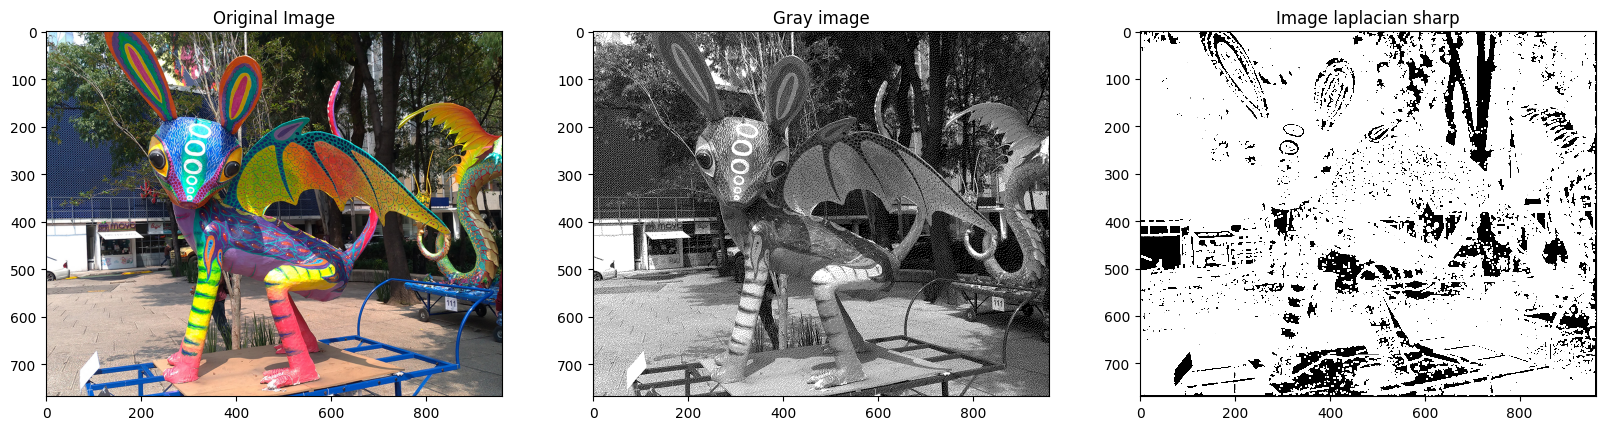

In [ ]:
display(dict_images, nrow=1, ncol=3)

### **2. Image enhancement and image masking**

> Implementa un algoritmo de realce o mejoramiento de imágenes mediante un algoritmo de en el cual se extraen las líneas de la imagen y después se aplica la diferencia con la imagen original, multiplicando los píxeles de la imagen “máscara” (las líneas encontradas) por un factor alfa mayor a 1.

####**Algotitmo Canny**



Es el detector de bordes más usado en la industria, hace uso de gradientes de la imagen (cambios en intensidad) para ejecutar la operación. Para la aplicación de este algoritmo de Canny en el siguiente ejemplo se tendrán en cuentan los siguientes aspectos:

> - Primero definiremos la función **line_enhancement** que toma una imagen y varios parámetros: **canny_threshold1 y canny_threshold2** que son los umbrales para la detección:
  - Si el **gradiente** es **>** que **canny_threshold2** se consideran **bordes**,
  - Si el resultado **son puntos**: el **gradiente** es **<** que **canny_threshold1.**
  - Los puntos intermedios son clasificados en base a su conectividad.

1. **Conversión a Escala de Grises:** La imagen original se convierte a escala de grises.
2. **Suavizado con Filtro Mediano:** Se aplica un filtro mediano para suavizar la imagen, lo cual es útil para reducir el ruido que podría afectar la detección de bordes.
3. **Detección de Bordes con Canny:** Se utiliza el algoritmo de Canny para detectar bordes en la imagen suavizada.
4. **Ajuste de la Intensidad de los Bordes:** La intensidad de los bordes detectados se ajusta multiplicándolos por un factor alpha.
5. **Combinación de Bordes Realzados con la Imagen Original:** Los bordes realzados se combinan con la imagen original utilizando una ponderación definida por beta.

###**Función matemática [1]** </br>
![Función matemática](https://i.imgur.com/f4wFbGH.png)</br></br>

###**Representación [2]** </br>
![Evidence 3](https://i.imgur.com/yOCuPP3.png)


######[1] Blog Detección de Bordes Canny. Tomado de: https://blog.csdn.net/
######[2] Blog Algoritmo de Canny. Tomado de: https://unipython.com/algoritmo-de-canny/

In [ ]:
import cv2
import matplotlib.pyplot as plt

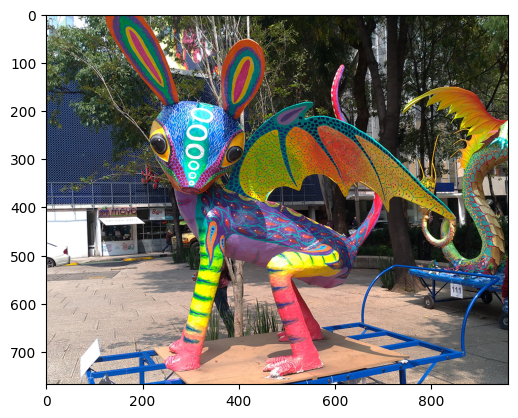

In [ ]:
original_image = Image.open('data/alebrije.jpg')
plt.imshow(original_image)
type(original_image)

# Save the image
np.save('data/img.npy', original_image)

**Función:**

In [ ]:
from google.colab.patches import cv2_imshow

Procesando imagen...
Proceso completado.


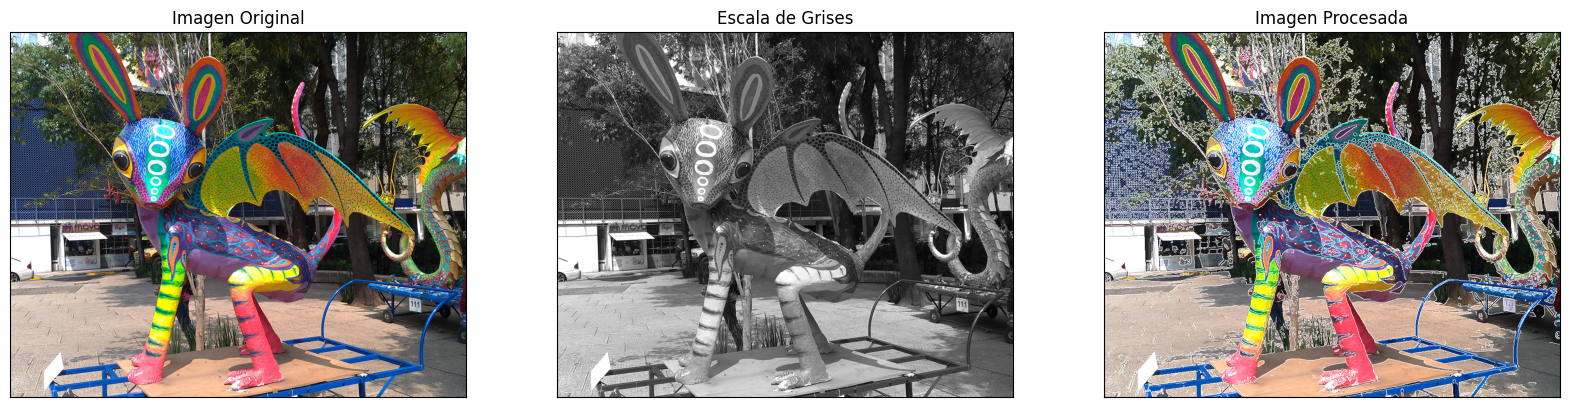

In [ ]:
def line_enhancement(img, alpha=1.5, beta=1, canny_threshold1=80, canny_threshold2=200, median_blur_ksize=3):
    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Suavizado con filtro mediano
    soften = cv2.medianBlur(gray, median_blur_ksize)

    # Detectar bordes con Canny
    edges = cv2.Canny(soften, canny_threshold1, canny_threshold2)

    # Ajustar la intensidad de los bordes
    enhanced_edges = np.clip(edges * alpha, 0, 255).astype(np.uint8)

    # Combinar bordes realzados con la imagen original
    enhanced_edges_colored = cv2.cvtColor(enhanced_edges, cv2.COLOR_GRAY2BGR)
    result = cv2.addWeighted(img, beta, enhanced_edges_colored, 1, 0)

    return gray, result

def plot_images(orig_img, gray_img, result_img):
    orig_img_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=[20, 10])
    plt.subplot(131), plt.imshow(orig_img_rgb)
    plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(gray_img, cmap='gray')
    plt.title('Escala de Grises'), plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(result_img_rgb)
    plt.title('Imagen Procesada'), plt.xticks([]), plt.yticks([])
    plt.show()

# Cargar la imagen
img_path = 'data/alebrije.jpg'
img = cv2.imread(img_path)

# Verificar si la imagen se ha cargado correctamente
if img is None:
    print("Error: no se pudo cargar la imagen.")
else:
    print("Procesando imagen...")
    gray_img, enhanced_img = line_enhancement(img)
    print("Proceso completado.")

    # Mostrar resultados
    plot_images(img, gray_img, enhanced_img)

### **3. Aplicación médica**

> Buscar una aplicación médica (en el libro de Gonzalez viene varios ejemplos de imágenes PET) y hacer mejoramiento usando la técnica de de la Figura 3.43 combinando diferentes etapas de procesamiento de imagenes.